In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
depth = 9    ##using d = (D+1)*S
d = 40

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def add_layerRZZ(data):
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])
            qml.RZ((pi-data[i])*(pi-data[j]), wires = j)
            qml.CNOT(wires = [i, j])

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    for i in range(2):
        add_layerRZ(data)
        add_layerRZZ(data)

In [5]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [6]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [7]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [8]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [9]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [11]:
fubini_matrices = []
eigen_vals = []
paramsV = []

In [12]:
np.random.seed(0)
data = np.random.uniform(-1, 1, numQubits)
data

array([0.09762701, 0.43037873, 0.20552675, 0.08976637])

In [13]:
start_qfi = time.time()

for i in range(100) :
    print(i)
    params = np.random.uniform(-1,1,d)
    print(params)
    paramsV.append(params)
    fubini = fubini_calculate(data, params, depth)
    print(fubini)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

0
[-0.1526904   0.29178823 -0.12482558  0.783546    0.92732552 -0.23311696
  0.58345008  0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414
 -0.95956321  0.66523969  0.5563135   0.7400243   0.95723668  0.59831713
 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343  0.88933783
  0.04369664 -0.17067612 -0.47088878  0.54846738 -0.08769934  0.1368679
 -0.9624204   0.23527099  0.22419145  0.23386799  0.88749616  0.3636406
 -0.2809842  -0.12593609  0.39526239 -0.87954906]
[[ 0.24865774 -0.02747065  0.05826672 ... -0.00247306 -0.08752646
   0.1311694 ]
 [-0.02747065  0.22017842 -0.04298277 ... -0.02555453  0.06710449
  -0.06362103]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.02105647 -0.04541962
   0.0376827 ]
 ...
 [-0.00247306 -0.02555453 -0.02105647 ...  0.23801952  0.05054704
  -0.03936482]
 [-0.08752646  0.06710449 -0.04541962 ...  0.05054704  0.24999916
  -0.13692381]
 [ 0.1311694  -0.06362103  0.0376827  ... -0.03936482 -0.13692381
   0.24976203]]
1
[ 0.33353343  0.341

[[ 0.24865774 -0.02747065  0.05826672 ...  0.02083021  0.03668536
   0.0120363 ]
 [-0.02747065  0.22017842 -0.04298277 ... -0.05012893  0.04007257
   0.05341168]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.06766034  0.01712062
   0.04702244]
 ...
 [ 0.02083021 -0.05012893 -0.06766034 ...  0.24943042 -0.01232814
  -0.02892442]
 [ 0.03668536  0.04007257  0.01712062 ... -0.01232814  0.24508798
   0.03702728]
 [ 0.0120363   0.05341168  0.04702244 ... -0.02892442  0.03702728
   0.23877623]]
9
[ 0.76408282 -0.08279208  0.44833527 -0.20194936  0.80808879  0.38005004
  0.39924411 -0.3445592   0.51355729  0.27212211 -0.51995945 -0.67892236
  0.59278295  0.91833321 -0.08372235  0.18196833  0.71544529 -0.08555309
  0.90374895  0.15150232  0.64153424  0.81768744  0.63104764 -0.68117107
  0.25779688 -0.20313148 -0.8745741  -0.1519355  -0.48263187  0.69807662
 -0.93339075  0.91796544 -0.2892623  -0.28658622 -0.96734299 -0.62953535
 -0.197481    0.85858283 -0.80077014  0.89060307]
[[ 0.24865774 -0.0

[[ 0.24865774 -0.02747065  0.05826672 ...  0.02468704 -0.01310729
  -0.06014202]
 [-0.02747065  0.22017842 -0.04298277 ...  0.00450259 -0.01784849
  -0.03862238]
 [ 0.05826672 -0.04298277  0.24569401 ...  0.00865975  0.03990334
  -0.0185325 ]
 ...
 [ 0.02468704  0.00450259  0.00865975 ...  0.20446176  0.00753799
  -0.06649623]
 [-0.01310729 -0.01784849  0.03990334 ...  0.00753799  0.24933691
  -0.04966436]
 [-0.06014202 -0.03862238 -0.0185325  ... -0.06649623 -0.04966436
   0.24997199]]
18
[-0.21486242  0.75674499  0.38156955  0.97469751  0.5185649  -0.27091075
  0.00212635 -0.24722169 -0.27017633 -0.478191   -0.00805941  0.36347989
 -0.44531946  0.04875962 -0.76523941 -0.68030943 -0.90638729  0.94146289
 -0.9922793  -0.64284006  0.22573351 -0.8372608   0.76379301  0.43924032
  0.93277994  0.01527109 -0.39919263  0.09900115  0.86163743  0.04152287
 -0.46558594  0.75479758 -0.2561625  -0.9972333  -0.50462996 -0.36353298
  0.71755494 -0.08299367 -0.11082542 -0.32779547]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ... -0.00660583  0.03648231
  -0.01202595]
 [-0.02747065  0.22017842 -0.04298277 ... -0.0680993  -0.07990859
  -0.00847958]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.06723494  0.00930778
  -0.02387435]
 ...
 [-0.00660583 -0.0680993  -0.06723494 ...  0.2072548   0.02101133
   0.04145145]
 [ 0.03648231 -0.07990859  0.00930778 ...  0.02101133  0.21589946
  -0.01577042]
 [-0.01202595 -0.00847958 -0.02387435 ...  0.04145145 -0.01577042
   0.23930882]]
27
[ 0.72224602  0.23531397 -0.91418762  0.4017113   0.82656868  0.04915413
 -0.29155036 -0.75944531  0.50980221  0.7700437  -0.79949651  0.51796911
 -0.96587903  0.93410984  0.23011604  0.10487812 -0.40810033  0.85858334
 -0.46818875  0.65629323  0.97021736  0.56679329  0.03797984 -0.86785147
 -0.05517242 -0.12348811 -0.59440792 -0.15282473 -0.28448423 -0.67263148
 -0.11725171 -0.47440009  0.04412484 -0.92967988  0.81246284  0.63272861
  0.10516267  0.70361717  0.92479015 -0.77895541]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ... -0.07620598  0.02734048
  -0.02323604]
 [-0.02747065  0.22017842 -0.04298277 ... -0.00642022 -0.05906744
   0.01500695]
 [ 0.05826672 -0.04298277  0.24569401 ...  0.0518772   0.02082848
   0.11452453]
 ...
 [-0.07620598 -0.00642022  0.0518772  ...  0.24902483 -0.00342615
  -0.00944399]
 [ 0.02734048 -0.05906744  0.02082848 ... -0.00342615  0.24261333
  -0.01880658]
 [-0.02323604  0.01500695  0.11452453 ... -0.00944399 -0.01880658
   0.24155058]]
36
[-0.43022896 -0.79202384  0.81579692  0.41810162  0.23055285  0.58499781
  0.67129208 -0.033082    0.7623765   0.83283802 -0.45689781  0.21509072
  0.05316806  0.07589156  0.87532619 -0.38962259  0.96686796  0.80426243
 -0.08255422  0.63490653  0.53809399  0.35578994 -0.36033222 -0.60709802
  0.34305539  0.68594659 -0.96749442  0.28560675 -0.11425395  0.79617551
 -0.35705414 -0.05163038  0.02953421 -0.71912096  0.42578461  0.66095269
 -0.88418145 -0.41722236 -0.92391064  0.91308821]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ... -0.10178767 -0.03426511
   0.02100118]
 [-0.02747065  0.22017842 -0.04298277 ... -0.02591133 -0.01981536
   0.06038927]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.06034396 -0.03359041
  -0.00668963]
 ...
 [-0.10178767 -0.02591133 -0.06034396 ...  0.23485821  0.06103802
  -0.02090774]
 [-0.03426511 -0.01981536 -0.03359041 ...  0.06103802  0.24784526
   0.06075171]
 [ 0.02100118  0.06038927 -0.00668963 ... -0.02090774  0.06075171
   0.24998119]]
45
[-0.96852352 -0.34829032  0.00501879 -0.94327413  0.1184966   0.74856555
  0.40946439  0.24593665  0.9119235   0.91655867  0.64853294  0.21548369
 -0.02447088 -0.97336777  0.21252381  0.97817615  0.6362021  -0.31879071
 -0.69590595  0.56811723  0.48787564  0.93409358  0.74968472  0.11132525
 -0.79743151 -0.03299868 -0.37260989  0.02481696 -0.39659685  0.72364598
  0.68865403 -0.36906969  0.19916269 -0.13963828  0.81818551 -0.6252782
  0.3954568   0.94075066 -0.64944896 -0.59606714]
[[ 0.24865774 -0.0

[[ 0.24865774 -0.02747065  0.05826672 ...  0.05413252  0.07104426
  -0.02249406]
 [-0.02747065  0.22017842 -0.04298277 ... -0.08901698  0.0269134
  -0.00453886]
 [ 0.05826672 -0.04298277  0.24569401 ...  0.01303631  0.01384126
   0.02153535]
 ...
 [ 0.05413252 -0.08901698  0.01303631 ...  0.23409375  0.06623868
   0.09458022]
 [ 0.07104426  0.0269134   0.01384126 ...  0.06623868  0.22993465
   0.06660542]
 [-0.02249406 -0.00453886  0.02153535 ...  0.09458022  0.06660542
   0.2480874 ]]
54
[ 0.66039316  0.68586972 -0.1707117  -0.15745321  0.85253176  0.32352719
 -0.83906563  0.08437391 -0.28798548  0.97486998 -0.97268919  0.22436175
  0.44724619 -0.42218646  0.94728304  0.71907325  0.83130568 -0.96153588
  0.1397443  -0.41069952  0.69805727  0.26569931  0.07775401 -0.77082366
  0.08044561  0.26380829  0.91182462  0.17010202  0.9348012   0.92321223
  0.30040067  0.01181597 -0.06795651  0.78075712 -0.94348663 -0.7723836
 -0.79585654  0.51387065 -0.32069795  0.27593709]
[[ 0.24865774 -0.02

[[ 0.24865774 -0.02747065  0.05826672 ...  0.03554457 -0.06184116
   0.02871885]
 [-0.02747065  0.22017842 -0.04298277 ...  0.01918251 -0.02681585
   0.00275138]
 [ 0.05826672 -0.04298277  0.24569401 ...  0.06154806  0.05726358
  -0.03644864]
 ...
 [ 0.03554457  0.01918251  0.06154806 ...  0.248558    0.05492273
  -0.08194393]
 [-0.06184116 -0.02681585  0.05726358 ...  0.05492273  0.24504074
  -0.07016365]
 [ 0.02871885  0.00275138 -0.03644864 ... -0.08194393 -0.07016365
   0.24479415]]
63
[-0.07672128 -0.26549717  0.87815671 -0.55525306  0.10708392 -0.89100369
 -0.61759561  0.20805387  0.32436731  0.16199164  0.73920283  0.98681044
  0.52772368 -0.06981643  0.66786934 -0.75922521  0.36654139  0.03667557
 -0.64386823  0.94586723 -0.32312516  0.23084681  0.75718848  0.01337769
 -0.7697243   0.63747817 -0.29357247  0.96613374  0.76765089  0.70689867
 -0.28749364  0.51425956  0.97265813  0.05264322 -0.05853569 -0.97066836
  0.40040754  0.71695514 -0.50508563 -0.36995085]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ... -0.00327461  0.10311633
   0.04972665]
 [-0.02747065  0.22017842 -0.04298277 ...  0.03185591 -0.02872835
  -0.02342323]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.00848075  0.06085943
   0.04933733]
 ...
 [-0.00327461  0.03185591 -0.00848075 ...  0.2481326   0.01540079
   0.00992387]
 [ 0.10311633 -0.02872835  0.06085943 ...  0.01540079  0.24952855
   0.04921381]
 [ 0.04972665 -0.02342323  0.04933733 ...  0.00992387  0.04921381
   0.24992577]]
72
[-0.86450756  0.56781095  0.93916474  0.88487124  0.4709676  -0.75281249
  0.15215353 -0.43153454  0.94042589  0.43497145  0.22153118  0.39017609
 -0.12404174 -0.2545265   0.87159916 -0.33614573 -0.91712774 -0.19831969
  0.58068071  0.29693672  0.92434155 -0.78759626  0.8230926  -0.26230161
 -0.05199483 -0.14303569 -0.76709544 -0.50440709  0.48454314 -0.95398492
 -0.73222445 -0.94957966  0.71477611  0.23464966 -0.66014268  0.53754445
  0.93360119  0.86912075  0.8430951  -0.98437957]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ... -0.04794756  0.00209685
  -0.03255176]
 [-0.02747065  0.22017842 -0.04298277 ... -0.0037697  -0.02435629
   0.05890237]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.01124416  0.03942368
  -0.00945899]
 ...
 [-0.04794756 -0.0037697  -0.01124416 ...  0.2337575   0.01161246
   0.02646646]
 [ 0.00209685 -0.02435629  0.03942368 ...  0.01161246  0.23329756
  -0.005082  ]
 [-0.03255176  0.05890237 -0.00945899 ...  0.02646646 -0.005082
   0.2359728 ]]
81
[ 0.49476356 -0.68859846 -0.04679215  0.87458708  0.86719919 -0.98150579
  0.50498282 -0.98752447  0.96860346 -0.1660656   0.94703752 -0.26450638
 -0.41362542 -0.36741607  0.46135813 -0.60065433  0.72811538  0.18114539
  0.93982205  0.97416981 -0.629636    0.91156411 -0.90692303 -0.94427255
  0.88772915  0.92479347 -0.70550465 -0.11516837 -0.01181494  0.72056247
  0.25583449  0.54913285 -0.02980631  0.2968274   0.47081872  0.47576257
 -0.99652435 -0.80018385 -0.27267912 -0.87760511]
[[ 0.24865774 -0.02

[[ 0.24865774 -0.02747065  0.05826672 ... -0.04694947 -0.00573106
  -0.01413858]
 [-0.02747065  0.22017842 -0.04298277 ...  0.07385764 -0.01067492
  -0.03575601]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.08247929 -0.02802761
   0.05235163]
 ...
 [-0.04694947  0.07385764 -0.08247929 ...  0.24791797 -0.05447111
  -0.06900591]
 [-0.00573106 -0.01067492 -0.02802761 ... -0.05447111  0.24819939
   0.04891322]
 [-0.01413858 -0.03575601  0.05235163 ... -0.06900591  0.04891322
   0.23420222]]
90
[-0.07637643 -0.1788426   0.55869854  0.03922736  0.32116428  0.13238596
  0.42437081 -0.81178999 -0.24475781 -0.66582162 -0.5159122  -0.59835145
  0.0066446  -0.96201402  0.9279352   0.03792765 -0.89485697  0.36410768
 -0.4622239  -0.78646481  0.66060737 -0.60418479 -0.79049146 -0.88618709
  0.45711549  0.31054249 -0.98360172 -0.55703892  0.40936406 -0.69571829
  0.15350157 -0.57368707 -0.10153143  0.73484612 -0.39480715  0.37194478
 -0.12343753 -0.80768949 -0.27873001  0.68256013]
[[ 0.24865774 -0.

[[ 0.24865774 -0.02747065  0.05826672 ...  0.01156612 -0.06500918
   0.01706199]
 [-0.02747065  0.22017842 -0.04298277 ... -0.05034831 -0.02424776
  -0.01297811]
 [ 0.05826672 -0.04298277  0.24569401 ... -0.01450774  0.07383396
  -0.04226023]
 ...
 [ 0.01156612 -0.05034831 -0.01450774 ...  0.2499894  -0.08437762
   0.05285002]
 [-0.06500918 -0.02424776  0.07383396 ... -0.08437762  0.24527249
  -0.14466322]
 [ 0.01706199 -0.01297811 -0.04226023 ...  0.05285002 -0.14466322
   0.24965375]]
99
[-0.79290561  0.54328958 -0.08542178 -0.73467609 -0.92557793  0.98675599
 -0.45126342  0.90449724  0.00367267  0.00603077 -0.81786056  0.90141164
  0.46579173  0.03745568 -0.75948572 -0.64864686 -0.13566679 -0.27548236
  0.11627601 -0.84731205 -0.91930796  0.02220617 -0.94299724 -0.88089609
 -0.24731708 -0.87644186 -0.22906075 -0.51649897 -0.62445941 -0.19064034
 -0.76019219 -0.30072127 -0.13025274  0.66000589  0.86561236 -0.38332313
 -0.4147159   0.13303655 -0.72517115 -0.30057563]
[[ 0.24865774 -0.

In [14]:
len(eigen_vals)

100

In [15]:
eigen_values = []
for i in range(0,len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])

In [16]:
len(eigen_values)

4000

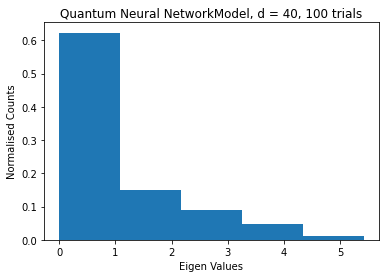

In [19]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5, density=True)
plt.title("Quantum Neural NetworkModel, d = 40, 100 trials")
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("QNN40")
plt.show()

In [20]:
import pickle
file_name = "QNN40DiffParams.pkl"

open_file = open(file_name, "wb")
pickle.dump([data,fubini_matrices,eigen_vals,paramsV], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()


In [21]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

[array([0.09762701, 0.43037873, 0.20552675, 0.08976637]), [array([[ 0.24865774, -0.02747065,  0.05826672, ..., -0.00247306,
        -0.08752646,  0.1311694 ],
       [-0.02747065,  0.22017842, -0.04298277, ..., -0.02555453,
         0.06710449, -0.06362103],
       [ 0.05826672, -0.04298277,  0.24569401, ..., -0.02105647,
        -0.04541962,  0.0376827 ],
       ...,
       [-0.00247306, -0.02555453, -0.02105647, ...,  0.23801952,
         0.05054704, -0.03936482],
       [-0.08752646,  0.06710449, -0.04541962, ...,  0.05054704,
         0.24999916, -0.13692381],
       [ 0.1311694 , -0.06362103,  0.0376827 , ..., -0.03936482,
        -0.13692381,  0.24976203]]), array([[ 2.48657741e-01, -2.74706504e-02,  5.82667159e-02, ...,
         3.82918312e-03,  5.14237744e-02, -8.46850227e-02],
       [-2.74706504e-02,  2.20178418e-01, -4.29827671e-02, ...,
         2.57071400e-02,  6.47437859e-02, -2.24144842e-04],
       [ 5.82667159e-02, -4.29827671e-02,  2.45694007e-01, ...,
        -4.6589